# PLVI-CE algorithm
In this notebook the PLVI-CE algorithm is tested.

## Train an initial classifier

In [1]:
from pathlib import Path

import numpy as np
from tensorflow import keras

from deepal_for_ecg.data.loader.ptbxl import PTBXLDataLoader
from deepal_for_ecg.data.module.active_learning import PTBXLActiveLearningDataModule
from deepal_for_ecg.strategies.query.random import RandomQueryStrategy
from deepal_for_ecg.train.time_series import MultiLabelTimeSeriesTrainer
from deepal_for_ecg.models.inception_network import InceptionNetworkConfig, InceptionNetworkBuilder

# load data
data_loader = PTBXLDataLoader(load_saved_data=True, saved_data_base_dir=Path('../data/saved/ptbxl'), raw_data_base_dir=Path("../data/raw"))
data_loader.load_data()
data_module = PTBXLActiveLearningDataModule(
    train_samples=data_loader.X_train,
    test_samples=data_loader.X_test,
    val_samples=data_loader.X_valid,
    train_labels_12sl=data_loader.Y_train_12sl,
    train_labels_ptb_xl=data_loader.Y_train_ptb_xl,
    test_labels=data_loader.Y_test,
    val_labels=data_loader.Y_valid
)

# select initial samples
num_initial_samples = 300
strategy = RandomQueryStrategy()
unlabeled_indices = data_module.state_dict()["unlabeled_indices"]
selected_samples = strategy.select_samples(num_initial_samples, unlabeled_indices)
data_module.update_annotations(buy_idx_ptb_xl=selected_samples, buy_idx_12sl=set())

# create the model
load_model = True
if not load_model:
    model_config = InceptionNetworkConfig()
    builder = InceptionNetworkBuilder()
    initial_model = builder.build_model(model_config)
else:
    initial_model = keras.models.load_model(Path("../experiments/al/plvi_ce_topk/initial_model.keras"))
    
log_dir = Path("../logs/al/plvi_ce_knn")
model_dir = Path("../models/al/plvi_ce_knn")


# train the classifier
def train(name: str):
    current_model = keras.models.clone_model(initial_model)
    trainer = MultiLabelTimeSeriesTrainer(model=current_model, model_name=name,
                                        num_labels=data_module.NUM_CLASSES,
                                        model_base_dir=str(model_dir),
                                        log_base_dir=str(log_dir), epochs=100)
    trainer.experiment_name = name
    trainer.fit(data_module.train_dataset, data_module.validation_dataset, verbose=True)
    return trainer.get_model(best=True)

best_model = train(name="initial")

2024-03-09 14:25:10.629068: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 14:25:10.629167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 14:25:10.673719: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-09 14:25:10.783119: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 14:25:12.654025: W tensorflow/compiler/tf2

Saving new best model with main validation metric: 0.5480932593345642
Saving new best model with main validation metric: 0.5581159591674805
Saving new best model with main validation metric: 0.5646989941596985
Saving new best model with main validation metric: 0.5709832310676575
Saving new best model with main validation metric: 0.574904203414917
Saving new best model with main validation metric: 0.587523341178894
Saving new best model with main validation metric: 0.6035634279251099
Saving new best model with main validation metric: 0.6136900186538696
Saving new best model with main validation metric: 0.6166853904724121
Saving new best model with main validation metric: 0.6200616359710693
Saving new best model with main validation metric: 0.6275118589401245
Saving new best model with main validation metric: 0.6656076312065125
Saving new best model with main validation metric: 0.6785656213760376
Saving new best model with main validation metric: 0.6835678815841675
Saving new best model 

## Test utilities

In [2]:
import tensorflow as tf

loss_object = keras.losses.BinaryCrossentropy()
test_loss = keras.metrics.Mean(name="validation_loss")
test_accuracy = keras.metrics.BinaryAccuracy(name="validation_accuracy")
test_auc = keras.metrics.AUC(multi_label=True, name="validation_auc", num_labels=PTBXLActiveLearningDataModule.NUM_CLASSES)

def reset_metrics():
    test_loss.reset_states()
    test_accuracy.reset_states()
    test_auc.reset_states()
    
@tf.function
def test_step(samples_batch, label_batch, model: keras.Model):
    sliding_window_predictions = []
    for sliding_window in samples_batch:
        sliding_window_predictions.append(model(sliding_window, training=False))

    predictions = tf.reduce_max(sliding_window_predictions, axis=0)
    t_loss = loss_object(label_batch, predictions)

    test_loss(t_loss)
    test_accuracy(label_batch, predictions)
    test_auc(label_batch, predictions)
    
def test(model: keras.Model):
    reset_metrics()
    for samples, labels in data_module.test_dataset.batch(128):
        test_step(samples, labels, model)
        
def calculate_label_coverage():
    selected_indices = list(data_module._labeled_indices_ptb_xl)
    selected_Labels = data_loader.Y_train_ptb_xl[selected_indices]
    samples_per_label = np.sum(selected_Labels, axis=0)
    return np.sum(samples_per_label >= 1) / 93

In [3]:
test(best_model)

auc = test_auc.result().numpy()
loss = test_loss.result().numpy()
accuracy = test_accuracy.result().numpy()
print(f"{auc = }, {accuracy = }, {loss = }")

auc_list = [auc]
accuracy_list = [accuracy]
loss_list = [loss]

coverage_list = [calculate_label_coverage()]
coverage_list

auc = 0.74509484, accuracy = 0.9342028, loss = 0.21418846


[0.7849462365591398]

## Use the PLVI-CE strategy

In [9]:
from deepal_for_ecg.strategies.query.plvi_ce import PredictedLabelVectorInconsistencyCrossEntropyStrategy

strategy = PredictedLabelVectorInconsistencyCrossEntropyStrategy()
sample_per_iteration = 150
al_iterations = 20
al_offset = 20

def print_step(heading: str):
    print(f"{heading:=^30}")

for i in range(al_offset + 1, al_offset + al_iterations + 1):
    # sampling
    print_step(f"AL iteration {i}")
    print_step("sampling")
    unlabeled_indices = data_module.state_dict()["unlabeled_indices"]
    selected_samples = strategy.select_samples(sample_per_iteration, data_module, data_loader, best_model)
    data_module.update_annotations(buy_idx_ptb_xl=selected_samples, buy_idx_12sl=set())
    coverage = calculate_label_coverage()
    print(f"{coverage = }")
    coverage_list.append(coverage)
    
    # training
    print_step("training")
    best_model = train(f"al_iteration_{i}")
    
    # testing
    test(best_model)
    auc = test_auc.result().numpy()
    loss = test_loss.result().numpy()
    accuracy = test_accuracy.result().numpy()
    print_step("testing")
    print(f"AL iteration {i} results: {auc = }, {accuracy = }, {loss = }")
    print("")
    print("")
    print("")

    auc_list.append(auc)
    accuracy_list.append(accuracy)
    loss_list.append(loss)

=======AL iteration 21========
===========sampling===========
coverage = 0.956989247311828
===========training===========
Saving new best model with main validation metric: 0.5348599553108215
Saving new best model with main validation metric: 0.5539535284042358
Saving new best model with main validation metric: 0.6050981283187866
Saving new best model with main validation metric: 0.6797917485237122
Saving new best model with main validation metric: 0.7349652051925659
Saving new best model with main validation metric: 0.7800654768943787
Saving new best model with main validation metric: 0.7954239845275879
Saving new best model with main validation metric: 0.7997732162475586
Saving new best model with main validation metric: 0.8148857355117798
Saving new best model with main validation metric: 0.8184435367584229
Saving new best model with main validation metric: 0.8196595907211304
Saving new best model with main validation metric: 0.8231163024902344
Saving new best model with main valida

## Results

### Save data and initial model

In [10]:
import pickle

p = Path("../experiments/al/plvi_ce_knn")
p.mkdir(parents=True, exist_ok=True)

results = {
    "selected_samples_indices": data_module.state_dict()["labeled_indices_ptb_xl"],
    "al_iterations": 40,
    "sample_per_iteration": 150,
    "auc_scores": auc_list,
    "coverage_over_time": coverage_list,
    "loss_scores": loss_list,
    "accuracy_scores": accuracy_list,
    "strategy_used": "PLVI-CE strategy with knn sample selection"
}

with open(Path(p, "results_40.pkl"), "wb") as f:
    pickle.dump(results, f)

initial_model.save(Path(p, "initial_model.keras"))

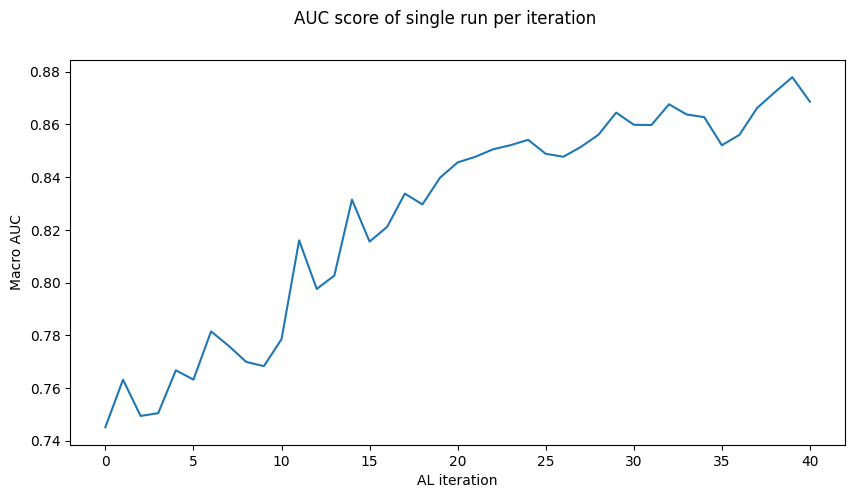

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize=(10, 5))
fig.suptitle("AUC score of single run per iteration")
plt.plot(auc_list, label="AUC")
plt.ylabel("Macro AUC")
plt.xlabel("AL iteration")
plt.show()
fig.savefig(Path(p, "auc_plot_40.png"))

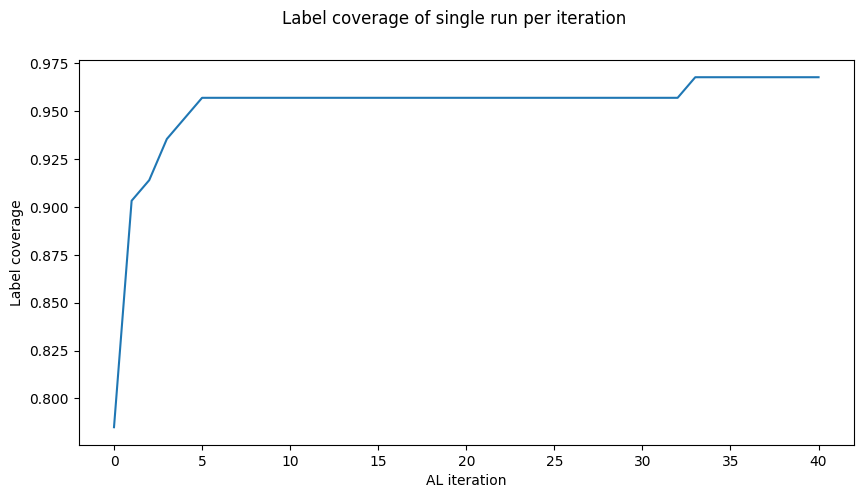

In [12]:
fig = plt.figure(1, figsize=(10, 5))
fig.suptitle("Label coverage of single run per iteration")
plt.plot(coverage_list, label="coverage")
plt.ylabel("Label coverage")
plt.xlabel("AL iteration")
plt.show()
fig.savefig(Path(p, "coverage_plot_40.png"))

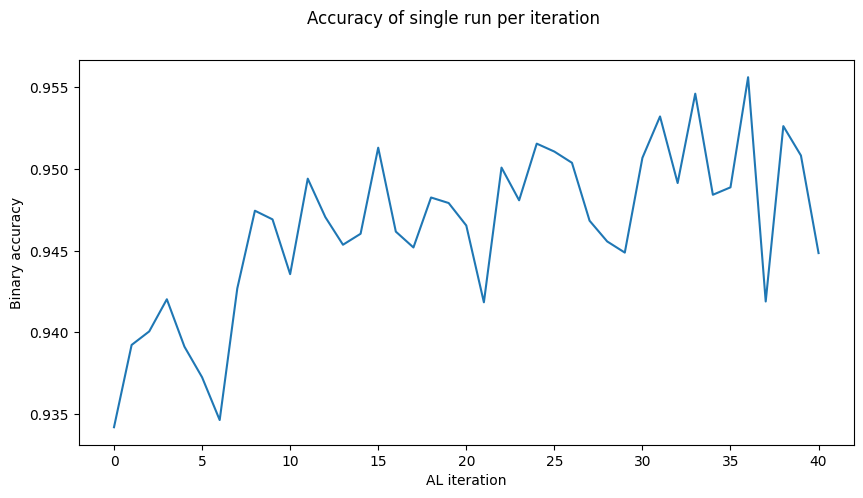

In [13]:
fig = plt.figure(1, figsize=(10, 5))
fig.suptitle("Accuracy of single run per iteration")
plt.plot(accuracy_list, label="accuracy")
plt.ylabel("Binary accuracy")
plt.xlabel("AL iteration")
plt.show()
fig.savefig(Path(p, "accuracy_plot_40.png"))

In [14]:
len(data_module.state_dict()["labeled_indices_ptb_xl"])

6300

In [15]:
len(data_module.state_dict()["unlabeled_indices"])

11118

In [16]:
6300/17418

0.36169479848432656